# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08

Clustering resources
- https://github.com/jrkreiger/instacart-analysis/blob/master/instacart-analysis.ipynb
- https://medium.com/towards-data-science/customer-segmentation-using-the-instacart-dataset-17e24be9c0fe


Other resources
- https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

# NOTAS PROF
- EXPERIMENTAR DBSCAN
- ADICIONAR E VALIDAR CENTROIDES

# File and libraries

In [16]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [17]:
%run "scripts/dslabs_functions.py"

# data functions

In [18]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [19]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group 1%   
    sample=0.1


    # data=pd.read_csv(filepath)

    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    users_df=users_df.sample(frac=sample)



# data=enrich_instacart_df(data)



users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33693 entries, 91806 to 57642
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  33693 non-null  int64  
 1   total_orders             33693 non-null  int64  
 2   mean_num_products        33693 non-null  float64
 3   mean_lag_between_orders  31869 non-null  float64
 4   mean_reorder_rate        33693 non-null  float64
 5   mean_weekend_order       33693 non-null  float64
 6   mean_order_dow           33693 non-null  float64
 7   median_order_hour        33693 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 2.3 MB


## variable type definition

In [51]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']

# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(users_df)
print(variable_types)


{'numeric': ['total_orders', 'mean_num_products', 'mean_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order', 'mean_order_dow', 'median_order_hour'], 'binary': ['kmeans_cluster', 'agglo_cluster'], 'date': [], 'symbolic': [], 'id': ['user_id']}


# Cluster Data Prep

## drop nulls

- this will drop all first buying orders from the dataframe

In [52]:
# drop any null values
# data=data.dropna()

users_df=users_df.dropna()

## Drop outliers

In [53]:
numeric_vars = variable_types["numeric"]

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour
count,12253.000000,12253.000000,12253.000000,12253.000000,12253.000000,12253.000000,12253.000000
mean,11.456541,10.169359,13.221874,0.492573,0.191822,2.600017,13.416714
std,6.345788,5.043101,6.186624,0.195296,0.227918,1.095928,2.928566
min,2.000000,1.000000,1.391304,0.113636,0.000000,0.444444,8.000000
25%,6.000000,6.157895,8.000000,0.333333,0.000000,1.769231,11.000000
50%,10.000000,9.642857,12.769231,0.500000,0.058824,2.600000,13.000000
75%,16.000000,13.742857,17.823529,0.645161,0.370968,3.461538,16.000000
max,25.000000,21.953846,27.125000,0.900000,0.757576,5.066667,19.000000


In [54]:

def drop_numeric_outliers(df, summary, numeric_vars, factor=1.5):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
	return df


numeric_vars = variable_types["numeric"]
users_df=drop_numeric_outliers(users_df, summary5, numeric_vars)

users_df=users_df[users_df['total_orders']<=25]

users_df

,user_id,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour,kmeans_cluster,agglo_cluster
131982,161457,13,7.000000,13.647059,0.764706,0.470588,3.647059,16.0,1,0
68629,83843,9,3.727273,7.636364,0.272727,0.000000,1.272727,12.0,0,0
163131,199606,5,10.928571,17.035714,0.357143,0.142857,2.571429,12.0,0,0
113650,138945,8,11.500000,4.464286,0.392857,0.000000,2.714286,14.0,0,0
13800,16819,11,8.066667,21.800000,0.200000,0.166667,1.333333,14.0,0,0
...,...,...,...,...,...,...,...,...,...,...
8943,10866,12,13.333333,15.537037,0.555556,0.425926,2.574074,16.0,1,0
119701,146351,16,11.708333,13.729167,0.479167,0.000000,2.020833,14.5,0,0
32856,40187,12,5.285714,18.857143,0.428571,0.000000,3.571429,11.0,0,0
85510,104513,16,16.591837,10.816327,0.693878,0.000000,0.979592,17.0,0,0


### New Outlier visualization

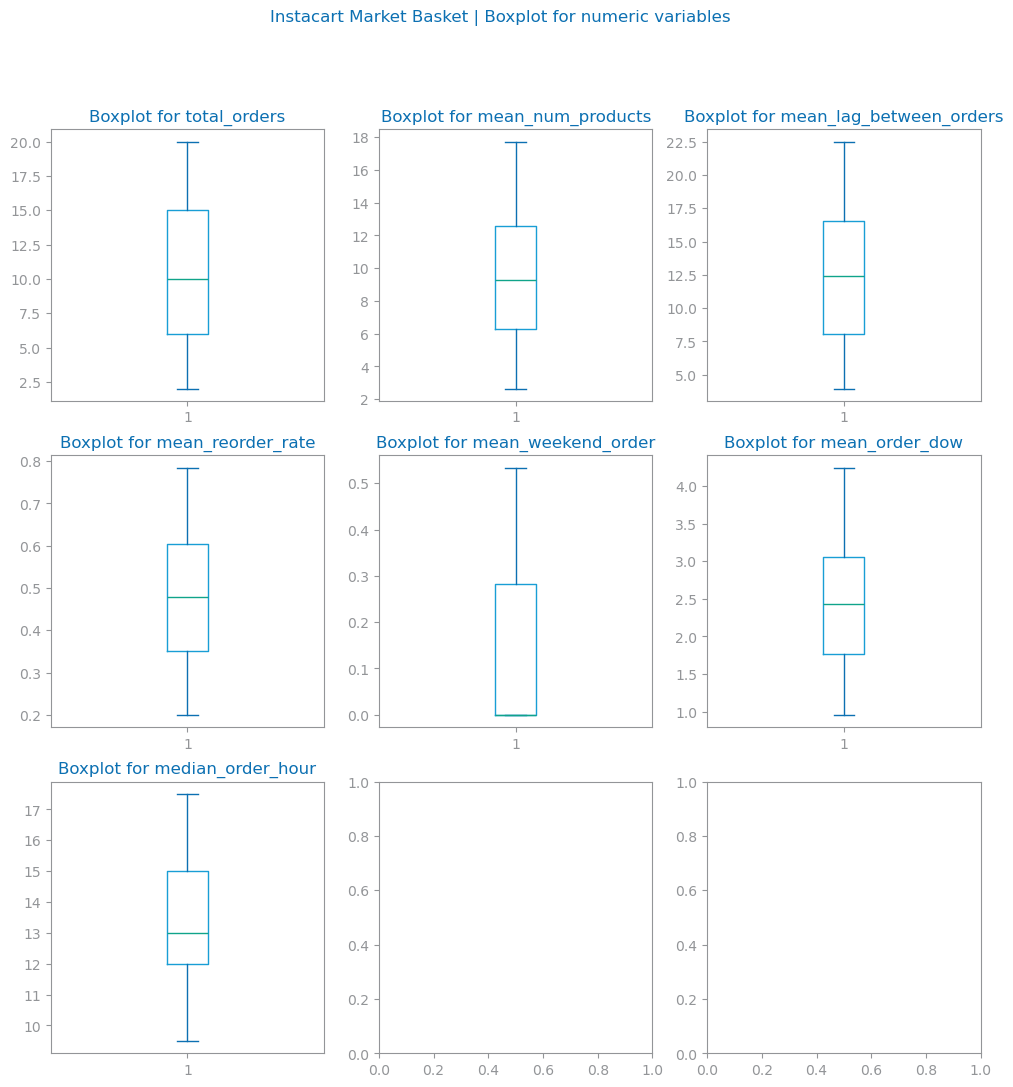

In [55]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## User Order feature selection and scaling

In [1]:

from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
reorder_numeric_features = users_df[numeric_vars]

# Normalize the data
scaler = StandardScaler()
reorder_numeric_features_scaled = scaler.fit_transform(reorder_numeric_features)


NameError: name 'users_df' is not defined

# User Order KMEANS clustering

## User Order Elbow Method Studies

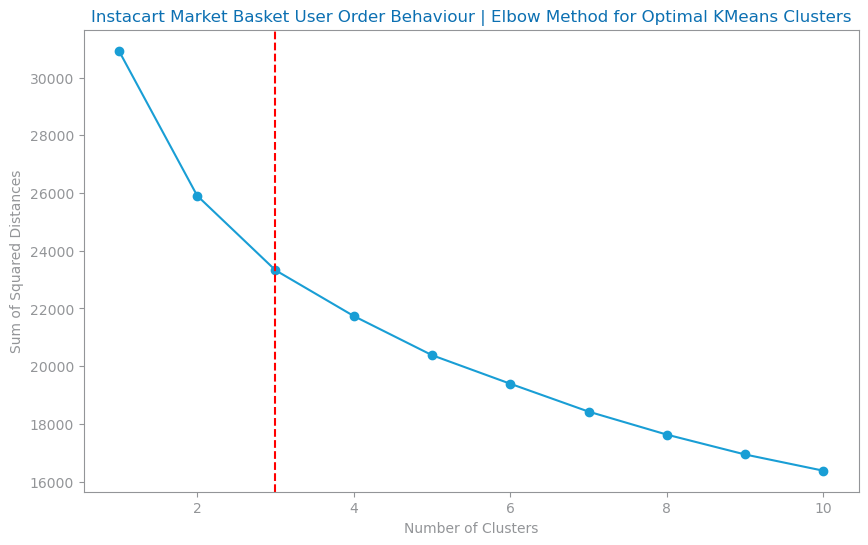

In [57]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reorder_numeric_features_scaled)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

## User Order Sillhouete study for kmeans

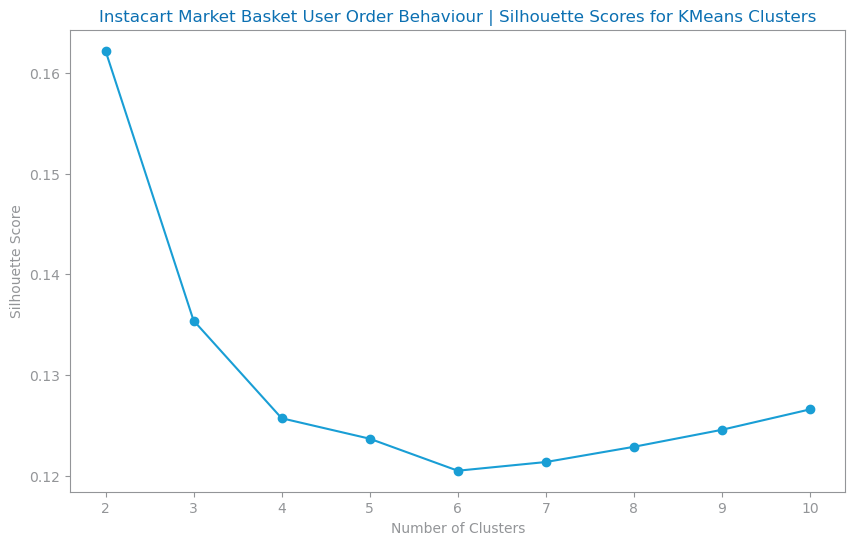

In [58]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reorder_numeric_features_scaled)
    silhouette_avg = silhouette_score(reorder_numeric_features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## User Order Kmeans model

In [59]:
# Clustering
reorder_kmeans = KMeans(n_clusters=2, random_state=42)
reorder_y_pred_kmeans = reorder_kmeans.fit_predict(reorder_numeric_features_scaled)

reorder_kmeans.cluster_centers_

array([[-0.27019827, -0.05911589, -0.00563971, -0.05246349, -0.67139829,
        -0.37110241,  0.00174243],
       [ 0.46008072,  0.10065971,  0.00960303,  0.08933232,  1.14322497,
         0.63189549, -0.00296693]])

# User Order Agglomerative

## User Order Sillouette Study for Agglomerative

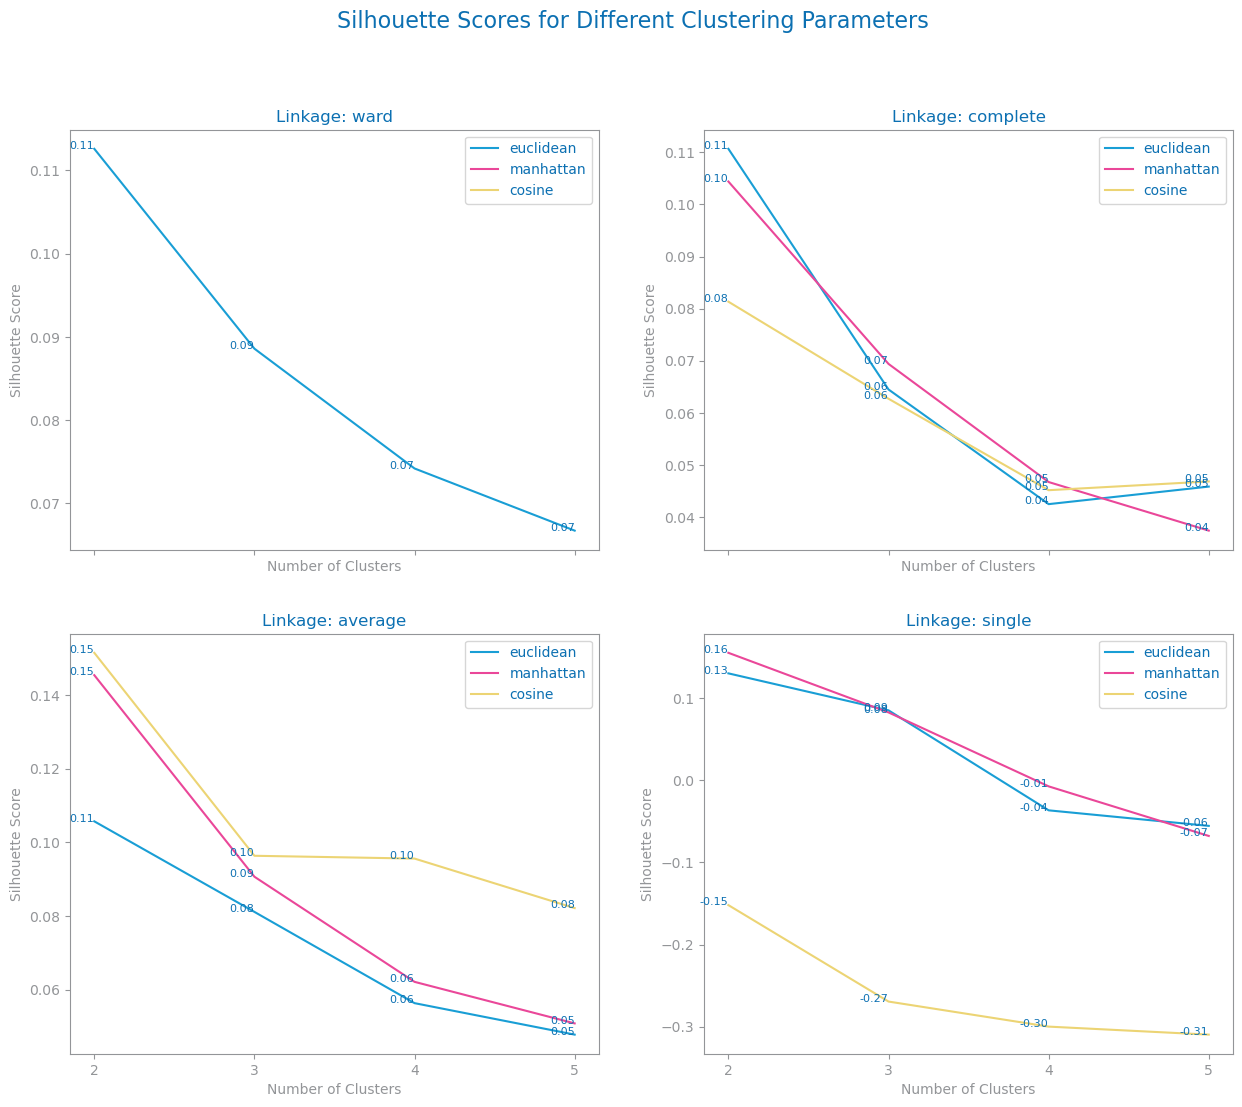

In [ ]:
# available in data functions py
evaluate_agglomerative_clustering(reorder_numeric_features_scaled, n_clusters_list=[2, 3, 4, 5], scale='no')

## User Order Dendrogram

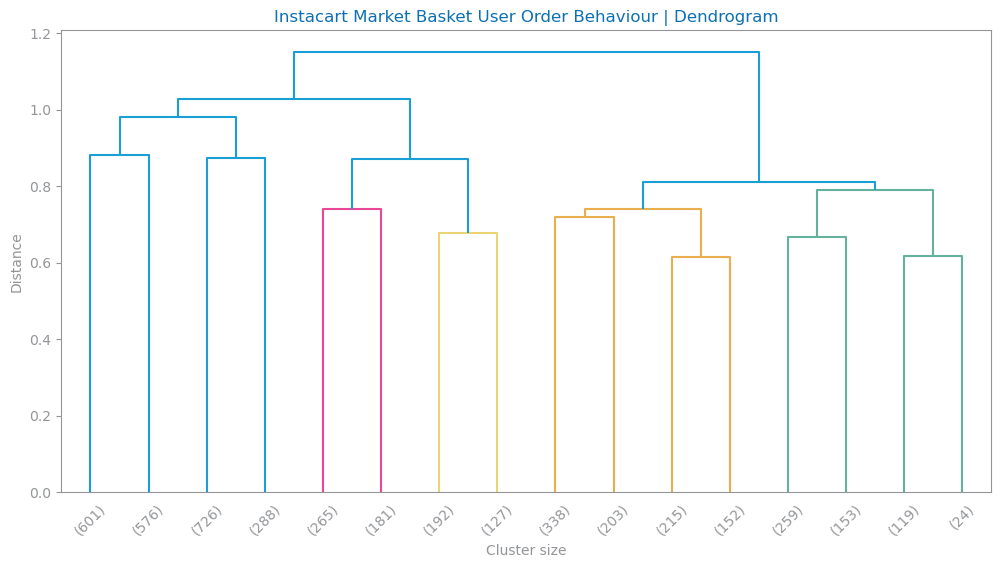

In [72]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(reorder_numeric_features_scaled, method='average', metric='cosine')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} User Order Behaviour | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


## User Order Agglomerative Model

In [73]:
reorder_agglo = AgglomerativeClustering(n_clusters=2, metric='cosine', linkage='average' )
reorder_y_pred_agglo = reorder_agglo.fit_predict(reorder_numeric_features_scaled)

reorder_y_pred_agglo

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

# Final User Order Model Evaluation

In [74]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
silhouette_agglo = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.16222181576019648
Silhouette Score for Agglomerative Clustering: 0.1514174384323264


## User Order Cluster Labeling

In [75]:
# Add cluster labels to the dataframe
users_df['kmeans_cluster'] = reorder_y_pred_kmeans
users_df['agglo_cluster'] = reorder_y_pred_agglo

# Display the dataframe with the new cluster labels
users_df.head()

,user_id,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour,kmeans_cluster,agglo_cluster
131982,161457,13,7.000000,13.647059,0.764706,0.470588,3.647059,16.0,1,1
68629,83843,9,3.727273,7.636364,0.272727,0.000000,1.272727,12.0,0,0
163131,199606,5,10.928571,17.035714,0.357143,0.142857,2.571429,12.0,0,0
113650,138945,8,11.500000,4.464286,0.392857,0.000000,2.714286,14.0,0,0
13800,16819,11,8.066667,21.800000,0.200000,0.166667,1.333333,14.0,0,0


### User Order Cluster Counts

In [2]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = users_df.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = users_df.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

NameError: name 'users_df' is not defined

In [66]:
agglo_weird_cluster = users_df[users_df['agglo_cluster']==1]

agglo_weird_cluster

,user_id,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour,kmeans_cluster,agglo_cluster
31540,38585,4,17.000000,16.000000,0.411765,0.000000,4.000000,16.0,0,1
78018,95353,6,16.354839,18.020833,0.354839,0.225806,2.741935,17.0,1,1
150429,184136,7,17.235294,22.000000,0.382353,0.000000,3.000000,17.0,0,1
140083,171455,3,17.242424,20.000000,0.333333,0.000000,2.606061,17.0,0,1
97454,119132,5,16.045455,21.173913,0.318182,0.000000,2.704545,16.0,0,1
123632,151172,6,16.041667,21.093750,0.270833,0.000000,2.291667,17.0,0,1
78501,95929,6,17.000000,19.000000,0.352941,0.000000,3.000000,17.0,0,1
85413,104389,10,17.682927,21.073171,0.243902,0.170732,3.097561,17.0,1,1
136397,166930,2,17.000000,15.000000,0.235294,0.000000,4.000000,15.0,0,1
14727,17980,5,16.702128,19.243243,0.297872,0.212766,3.425532,15.0,1,1


### User Order cluster boxplots

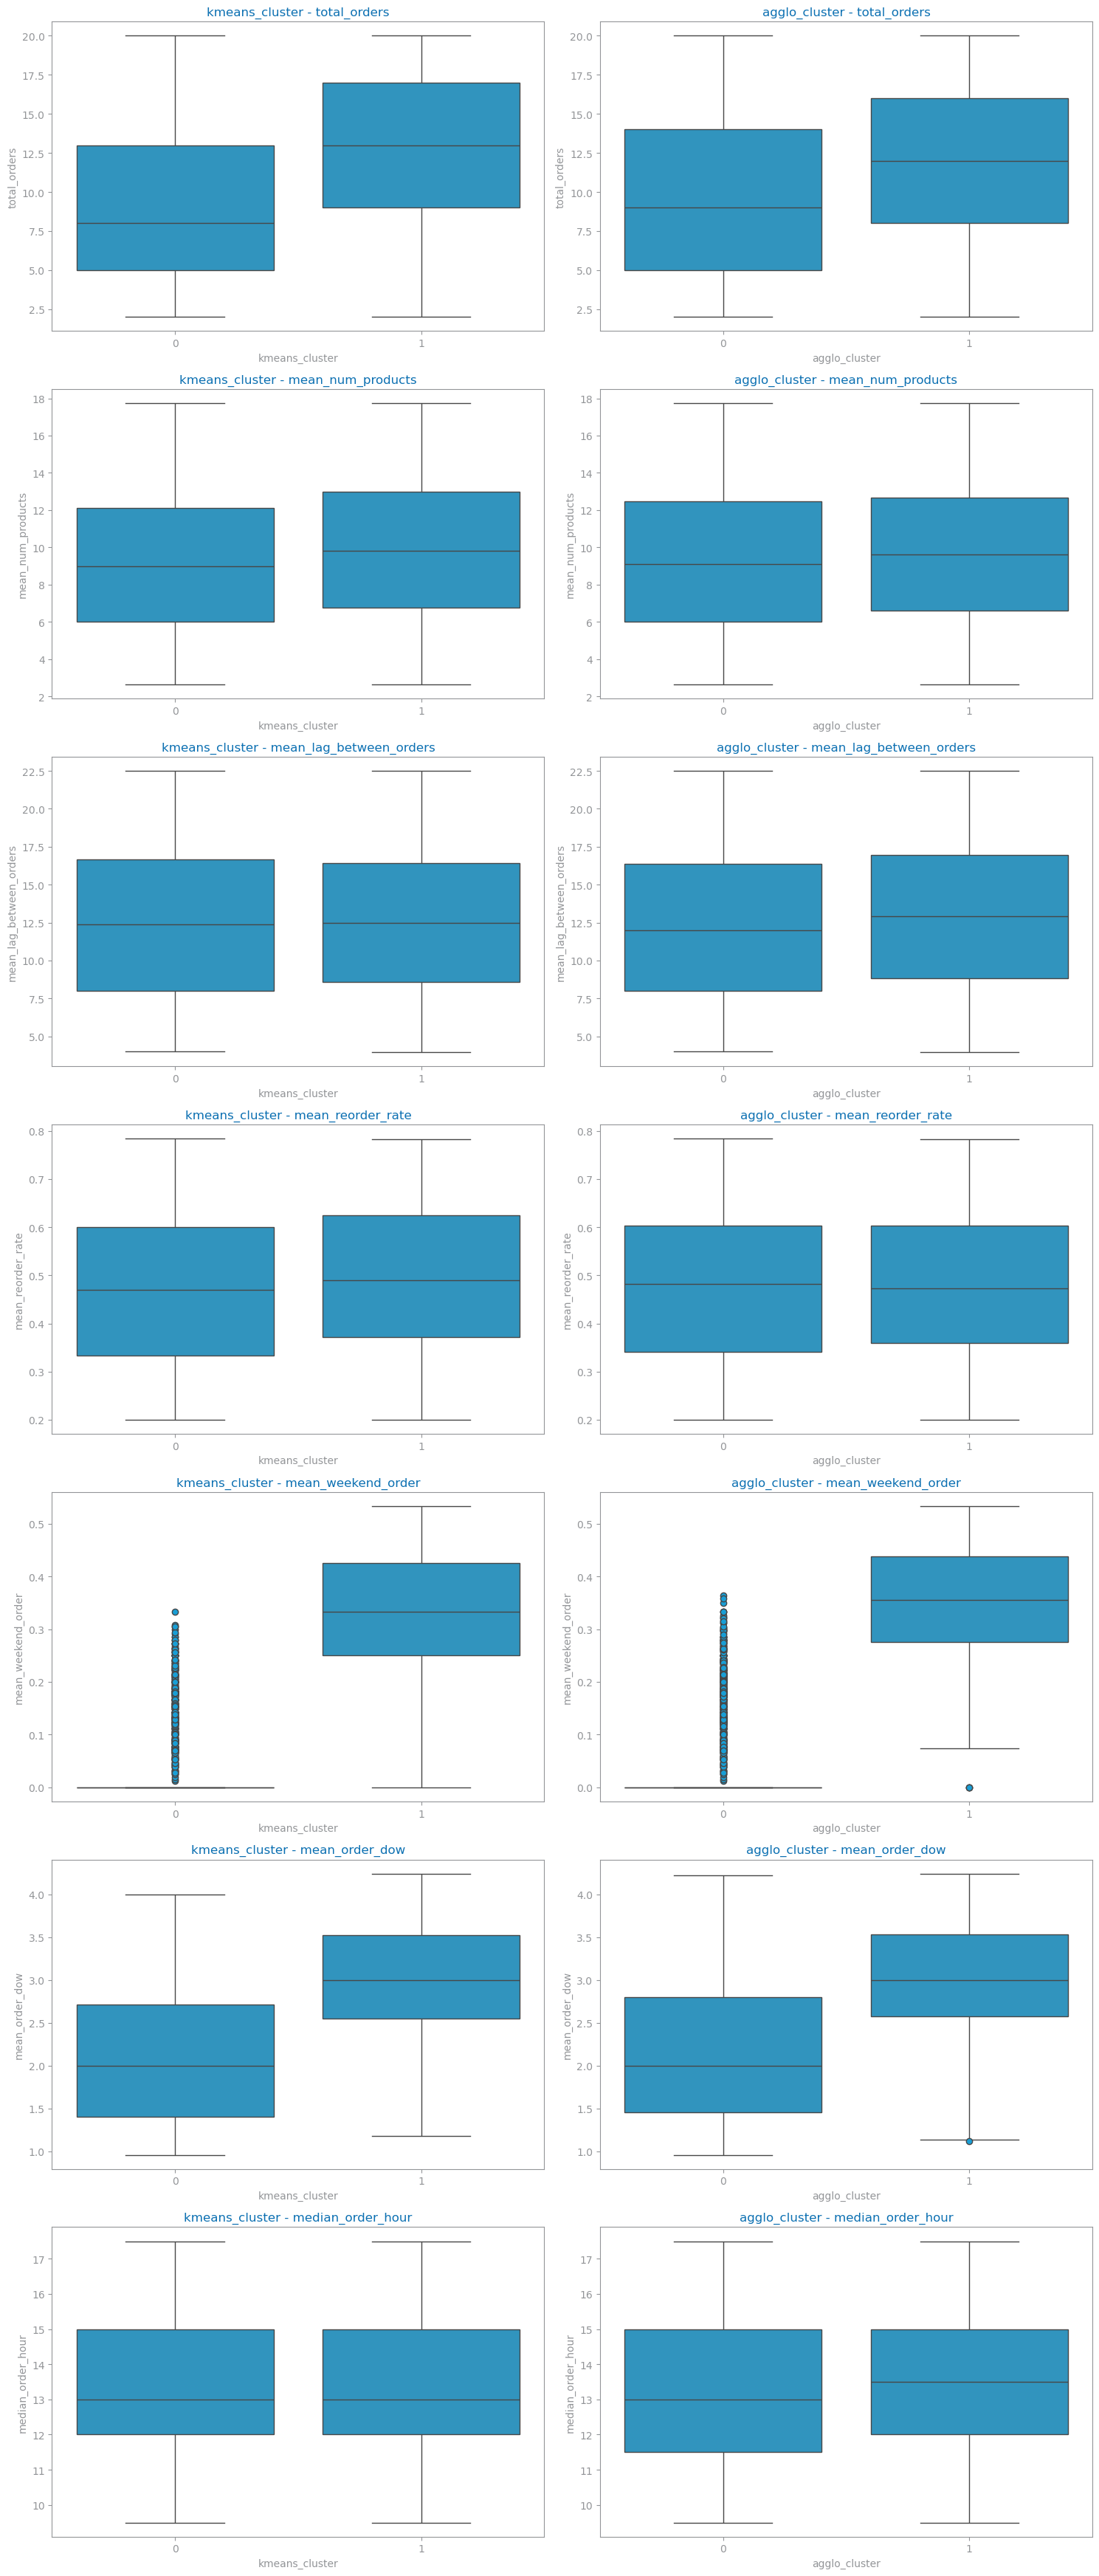

In [77]:

# Example usage
features = numeric_vars


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(users_df, features, cluster_labels)

## User Order PCA visualization

In [78]:
from sklearn.decomposition import PCA

# Visualization
pca_reorder = PCA(n_components=6)
numeric_features_pca = pca_reorder.fit_transform(reorder_numeric_features_scaled)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,2.599017,-0.185011,-0.908678,1.286388,0.514383,0.836274
1,-1.738243,0.267580,-1.241109,-1.036334,-0.167371,-1.384709
2,-0.547021,1.050453,0.877761,-0.585861,0.651541,0.365785
3,-0.657266,0.439276,-0.525110,-0.277721,-1.629132,0.361978
4,-0.943730,0.943847,1.177913,0.454520,1.209342,-1.794241


## User Order pca explained variance ratio

In [79]:
# Fit the PCA model
pca_reorder.fit(reorder_numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_reorder}')


Explained variance ratio: [0.2266113  0.16750973 0.15027046 0.14209286 0.13990889 0.10285501]


## User Order pca plot

### 2D PCA Plot

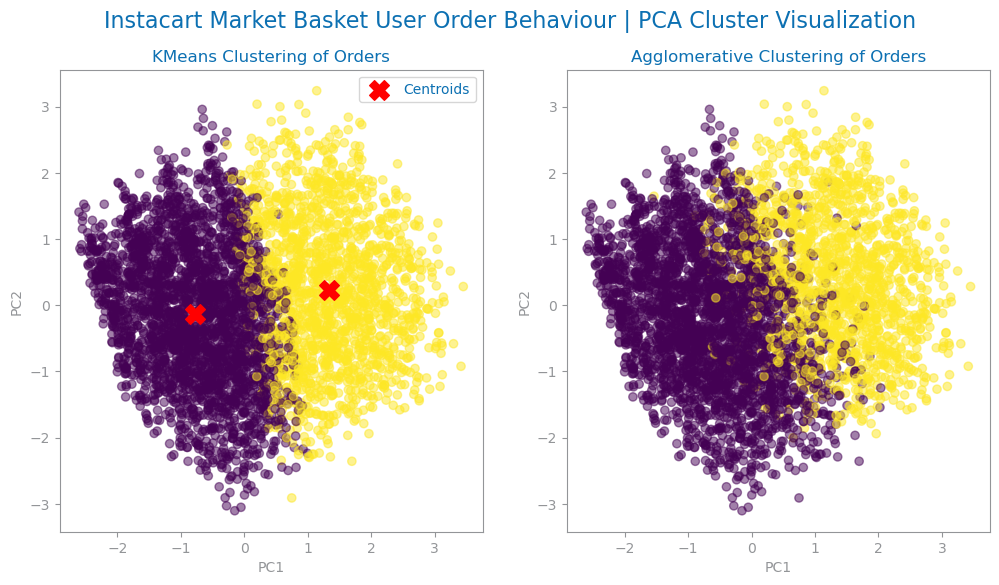

In [85]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca_reorder.transform(reorder_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Orders')

plt.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

### PCA Plot 3D

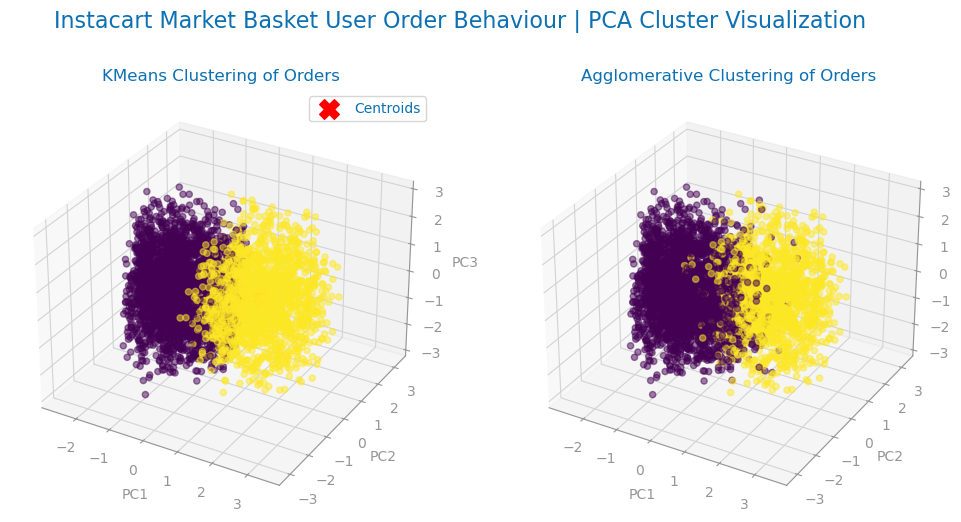

In [88]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca_reorder.transform(reorder_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering of Orders')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Orders')

fig.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

# outputs
